# Ets in putative heart enhancers

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO

#########################################################################################
# These methods can be found on my gitub
# see https://github.com/jsolvason/js/tree/6623ca2c3ee871eca8defbac5b85fcb4036eb7a4
#    for methods used here at time of publication

import jsDna as jsd
import js

In [2]:
####################################################################################
# Download data form wei 2010, 
# http://the_brain.bwh.harvard.edu/uniprobe/detailsDef.php?id=414
# Mouse ETS1 pbm data
def loadEts():
    ref  =f'/projects/ps-farleylab/users/solvason/ref/binding-affinity/ets/parsed_Ets1_8mers.txt'              
    Seq2EtsAff  = {line.split('\t')[0]:float(line.split('\t')[1]) for line in open(ref,'r').readlines()}
    return Seq2EtsAff

Ets2Aff=loadEts()



In [3]:
####################################################################################
# Load hg38  genome

d="/projects/ps-farleylab/users/solvason/ref/genome/"
def loadHg38():
    file_genome=f'{d}/human/hg38/hg38.fa'
    Handle = open(file_genome, "r")
    chr2seq = SeqIO.to_dict(SeqIO.parse(Handle, "fasta"))
    chr2seq = {chrom:str(chr2seq[chrom].seq).upper() for chrom in chr2seq}
    return chr2seq

# Load 2019 ciona genome
def loadCi19():
    file_genome=f'{d}/ciona/2019/HT.Ref.fasta'
    Handle = open(file_genome, "r")
    chr2seq = SeqIO.to_dict(SeqIO.parse(Handle, "fasta"))
    chr2seq = {chrom:str(chr2seq[chrom].seq).upper() for chrom in chr2seq}
    return chr2seq

# Load genomes

In [4]:
G2Chr2Seq={}

G2Chr2Seq['Ci19']=loadCi19()
G2Chr2Seq['hg38']=loadHg38()

# Analyze ets affinities

In [5]:
Ets2RoundedAff={kmer:round(float(aff),2) for kmer,aff in Ets2Aff.items()}
js.dprint(Ets2RoundedAff,2)

AAAAAAAA 0.15
TTTTTTTT 0.15
AAAAAAAC 0.11


In [6]:
Genome2Organism={
    'Ci19':'Ciona',
    'hg38':'Human'
}

d='/home/solvason/projects/ets/heart/0-affinity-optimization-potential/'
Genome2Name2Bed={
    'Ci19':{'Heart-Open-Chromatin-Racioppi'   :f'{d}/ciona/racciopi-atac-mespPositive/LacZ_6hpf_13_peaks_noexon_top90.bed'},
    
    'hg38': {
        'Heart-Put-Dev-En-Benaglio-Dantonio-May-Richter':'/home/solvason/projects/ets/heart/0-affinity-optimization-potential/human/7-heart-fetal-enhancers-multipleDatasets-forcellpaper/merged.bed.sorted',
        'Heart-Put-Dev-En-Benaglio-Dantonio-May-Richter-associated-GWAS':    '/home/solvason/projects/ets/heart/0-affinity-optimization-potential/human/8-heart-feta-enhancers-associated-gwas-dnv/putativeFetalEn-associated-gwas.bed',
    }
}

Name2Xlabel={
    'Heart-Put-Dev-En-Benaglio-Dantonio-May-Richter':'Heart-Put-Dev-En\nBenaglio-Dantonio\nMay-Richter',
    'Heart-Open-Chromatin-Racioppi':'Heart-Open-Chromatin\nRacioppi',
    'Heart-Put-Dev-En-Benaglio-Dantonio-May-Richter-associated-GWAS':'Heart-Put-Dev-En\nBenaglio-Dantonio\nMay-Richter\nassociated-GWAS'
}

scn5a='GCTTCCGG' 
mars2='AAGGAAAT'
ryr2='TCTTCCGG'
zfhx3='ACGGAAAC'
sh3yl1='CAGGAAGC'
diseaseKmers =[scn5a,mars2,ryr2,zfhx3,sh3yl1]
xAdjustCustom=[0,+1,-1,-1,+1]# see cell below to adjust x axis so the dots dont overlap on scatter

Genome2Name2DiseaseKmers={
    'Ci19':{'Heart-Open-Chromatin-Racioppi' : ([],[])},
    'hg38':{
        'Heart-Put-Dev-En-Benaglio-Dantonio-May-Richter':                    (diseaseKmers,xAdjustCustom),
        # '\nHeart Put Dev En\nAng et al\nBenaglio et al\nDantonio et al\nMay et al\nRichter et al\nAssociated DNV':      (diseaseKmers,xAdjustCustom),
        'Heart-Put-Dev-En-Benaglio-Dantonio-May-Richter-associated-GWAS':     (diseaseKmers,xAdjustCustom),
        # '\nHeart Put Dev En\nAng et al\nBenaglio et al\nDantonio et al\nMay et al\nRichter et al\nAssociated DNV or GWAS': (diseaseKmers,xAdjustCustom),
        # '\nHeart Put Dev En\nAng et al\nBenaglio et al\nDantonio et al\nMay et al\nRichter et al\nAssociated eQTL Matteo bp<.05': ([],[]),
    },
    
}
 

In [7]:
etsTfCores=set(['GGAA','GGAT','TTCC','ATCC'])


def checkIfSnvCausesDramaticIncrease(ref8mer,Ets2RoundedAff,foldChangeCutoff):
    
    kmer=ref8mer
    aff=Ets2RoundedAff[kmer]
    
    SnvCausesDramaticIncrease=False
    DramaticIncreaseFoldChanges=[]
    # If low aff ets, see which snvs cause dramatic affinity increase
    for i in range(len(kmer)):

        # Create all possible snvs
        kmerDegenerate=kmer[:i]+'N'+kmer[i+1:]
        core=kmerDegenerate[2:6]
        
        if core not in etsTfCores: continue 
            
        allSnvs=jsd.GenerateAllPossibleSequences(kmerDegenerate)
        for snv in allSnvs:

            snvAff=Ets2RoundedAff[snv]
            foldChange=snvAff/aff

            # If affinity jump is sufficient, save 
            if foldChange>=foldChangeCutoff:
                SnvCausesDramaticIncrease=True
                DramaticIncreaseFoldChanges.append(foldChange)
    
    if DramaticIncreaseFoldChanges!=[]:
        return SnvCausesDramaticIncrease,max(DramaticIncreaseFoldChanges)
    else:
        return SnvCausesDramaticIncrease,False
    
checkIfSnvCausesDramaticIncrease('AAGGAATT',Ets2RoundedAff,3)

(True, 3.5454545454545454)

# Option 2: Violin + pie chart

In [8]:
donut=True
pop=True
inner=False

---------------------------------------------------------------------------------
Ci19

	 Heart-Open-Chromatin-Racioppi /home/solvason/projects/ets/heart/0-affinity-optimization-potential//ciona/racciopi-atac-mespPositive/LacZ_6hpf_13_peaks_noexon_top90.bed
Heart-Open-Chromatin-Racioppi
	N Put Enhancers Total                             = 15,174
	N Put Enhancers With Dramatic Aff Increase        = 6,618 (43.6 %)

	N Ets in Put Enhancers Total                      = 56,367
	N Ets in Put Enhancers With Dramatic Aff Increase = 11,630 (20.6 %)

Average Putative Dev Enhancer ETS     = 0.12
Average Putative Dev Enhancer ETS-SNV = 0.52
([], [])
[0.2, 0.5, 0.7, 0.8, 0.9, 1]


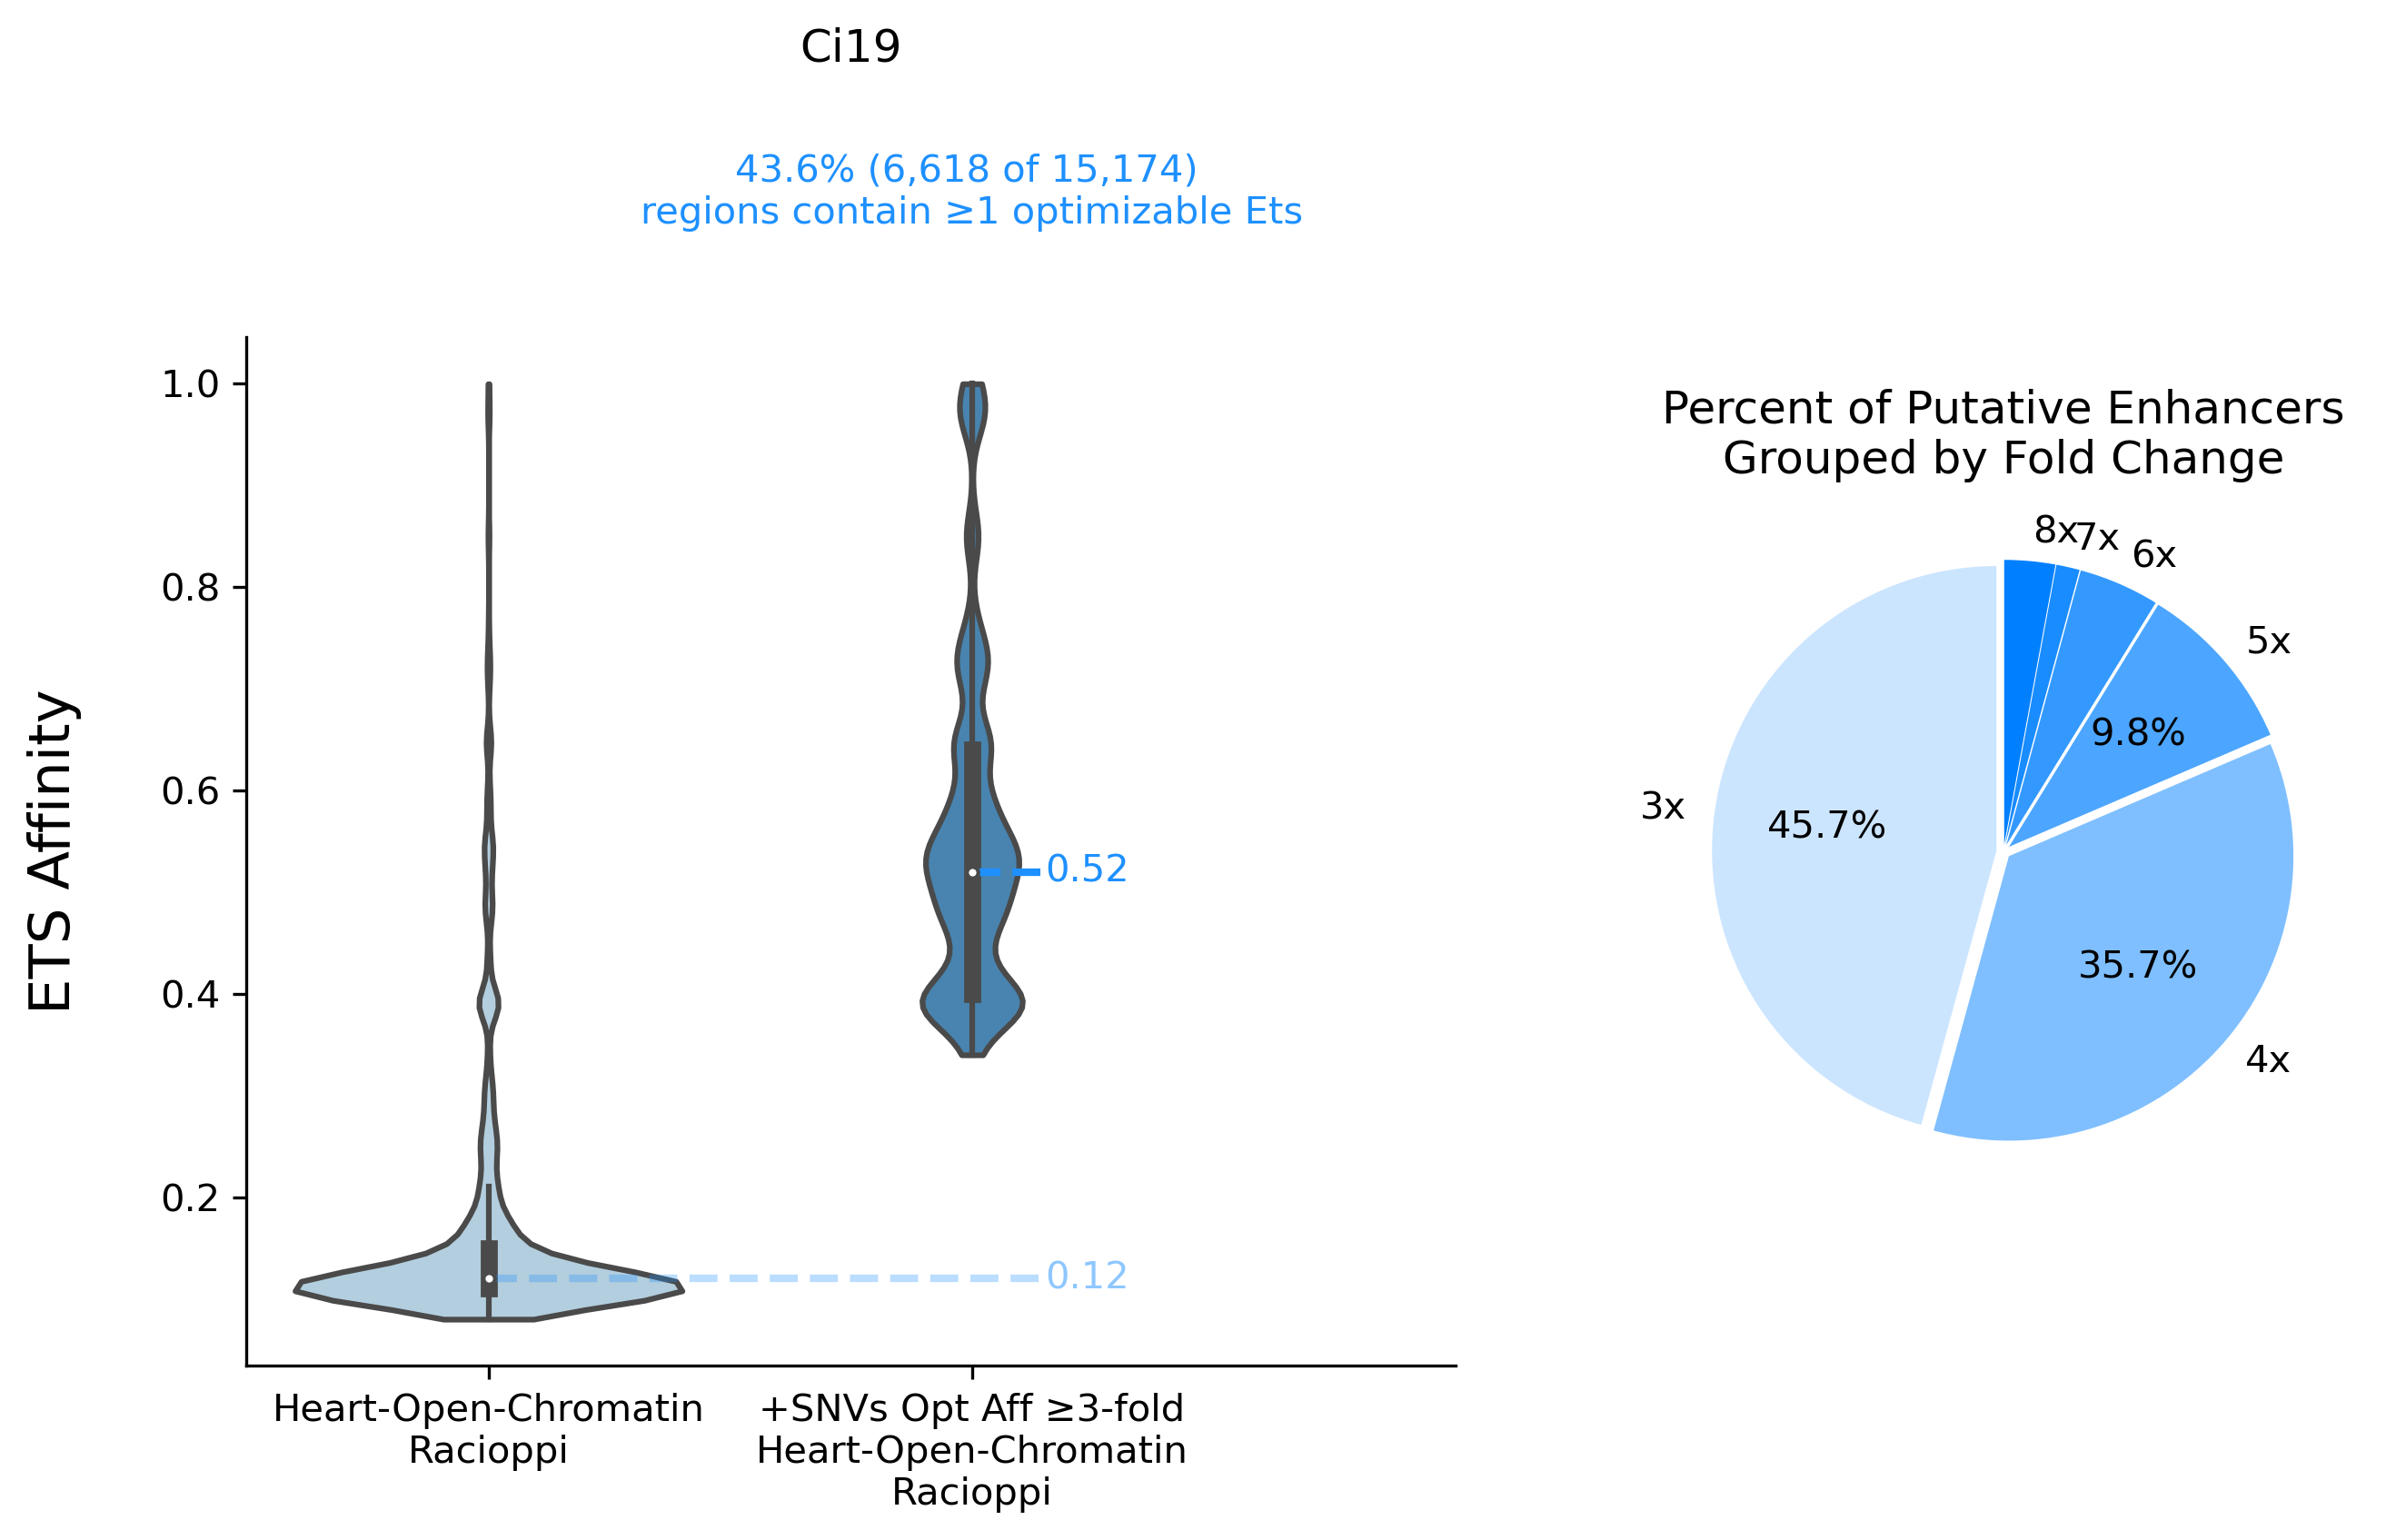

([], [])
[0.2, 0.5, 0.7, 0.8, 0.9, 1]


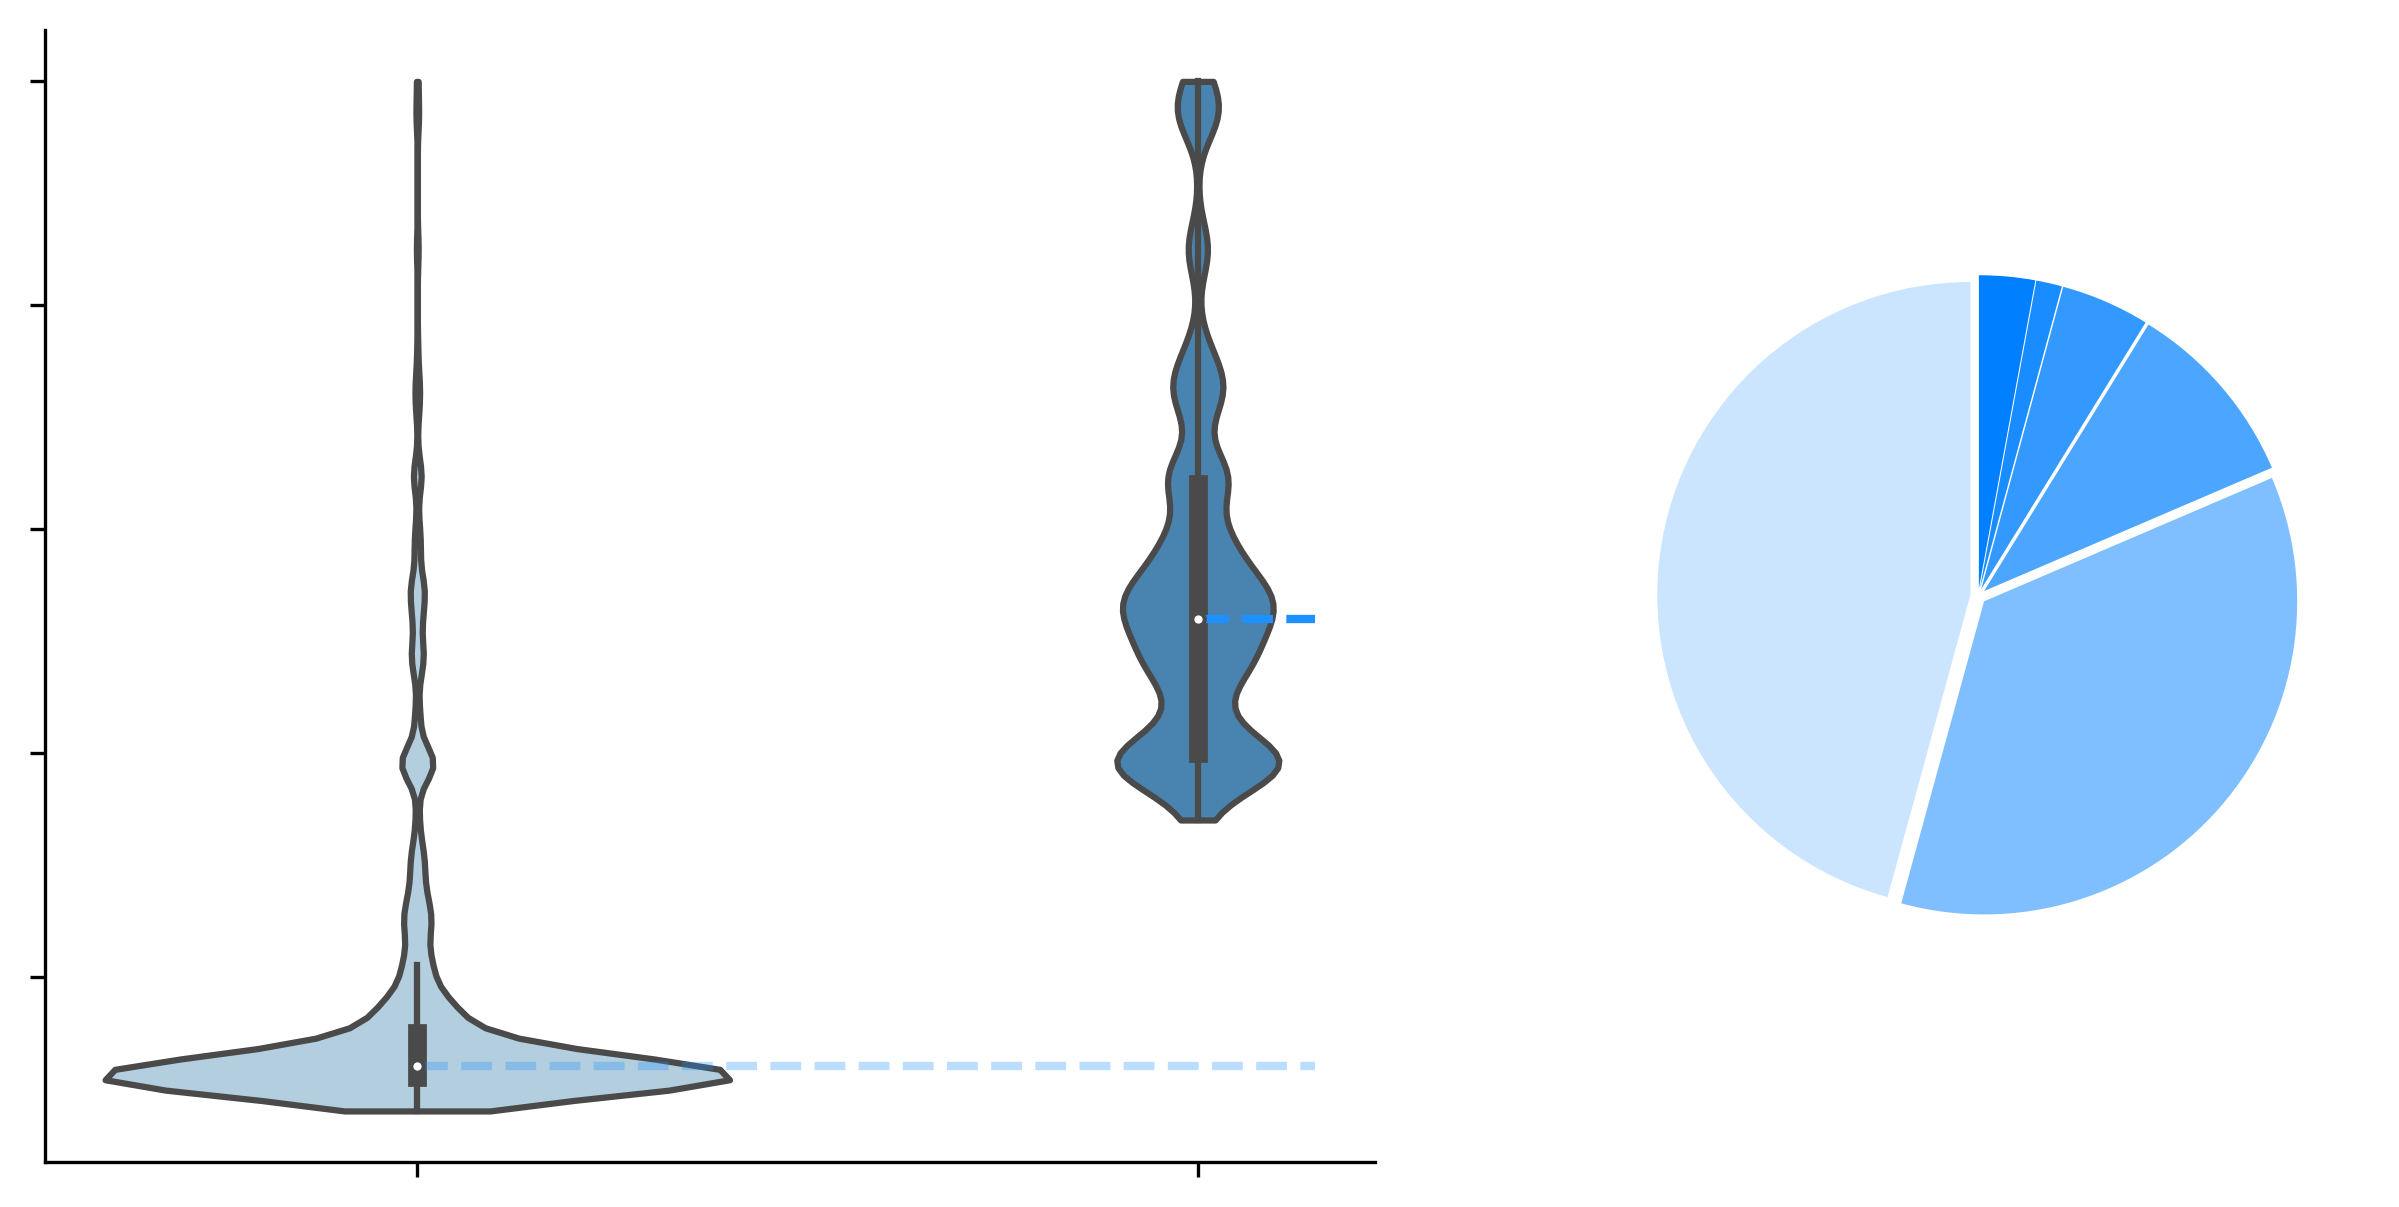

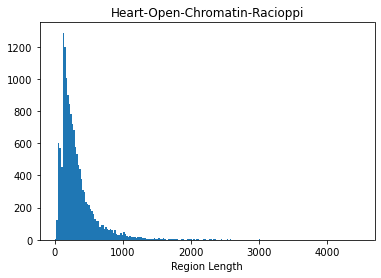

---------------------------------------------------------------------------------
hg38

	 Heart-Put-Dev-En-Benaglio-Dantonio-May-Richter /home/solvason/projects/ets/heart/0-affinity-optimization-potential/human/7-heart-fetal-enhancers-multipleDatasets-forcellpaper/merged.bed.sorted
Heart-Put-Dev-En-Benaglio-Dantonio-May-Richter
	N Put Enhancers Total                             = 197,963
	N Put Enhancers With Dramatic Aff Increase        = 129,822 (65.6 %)

	N Ets in Put Enhancers Total                      = 6,916,848
	N Ets in Put Enhancers With Dramatic Aff Increase = 1,364,519 (19.7 %)

Average Putative Dev Enhancer ETS     = 0.12
Average Putative Dev Enhancer ETS-SNV = 0.52
(['GCTTCCGG', 'AAGGAAAT', 'TCTTCCGG', 'ACGGAAAC', 'CAGGAAGC'], [0, 1, -1, -1, 1])
[0.2, 0.5, 0.7, 0.8, 0.9, 1]


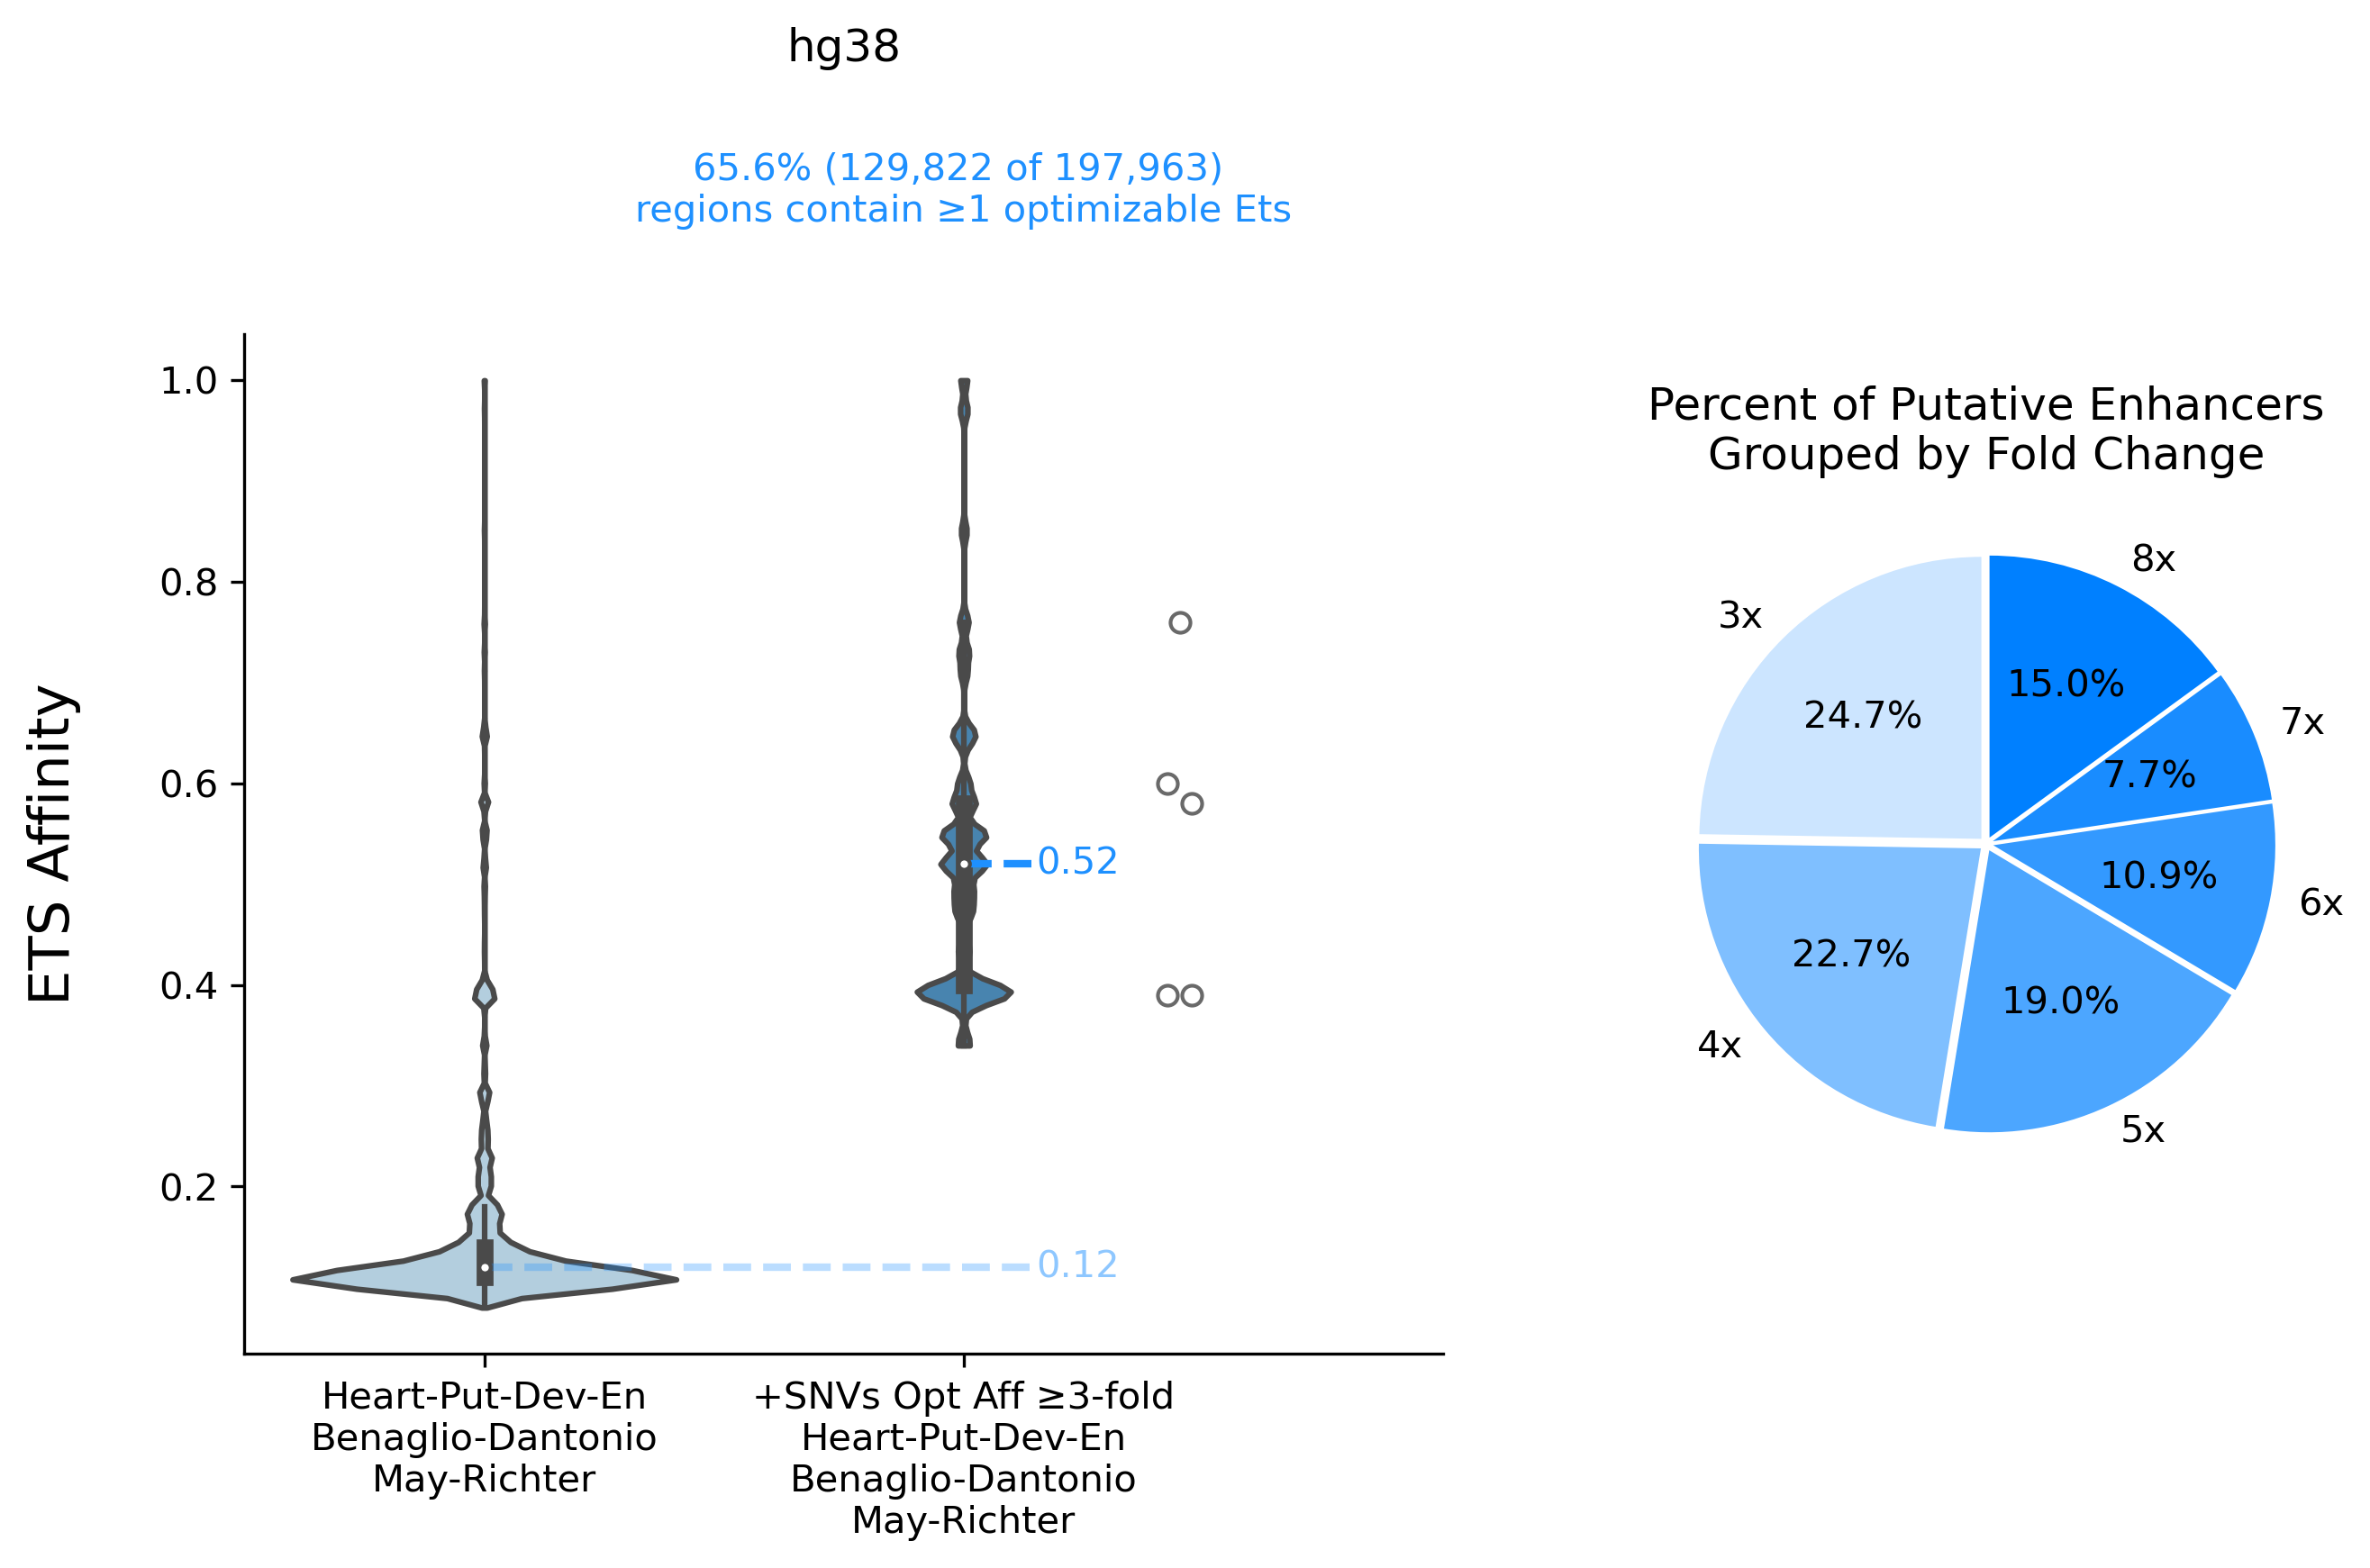

(['GCTTCCGG', 'AAGGAAAT', 'TCTTCCGG', 'ACGGAAAC', 'CAGGAAGC'], [0, 1, -1, -1, 1])
[0.2, 0.5, 0.7, 0.8, 0.9, 1]


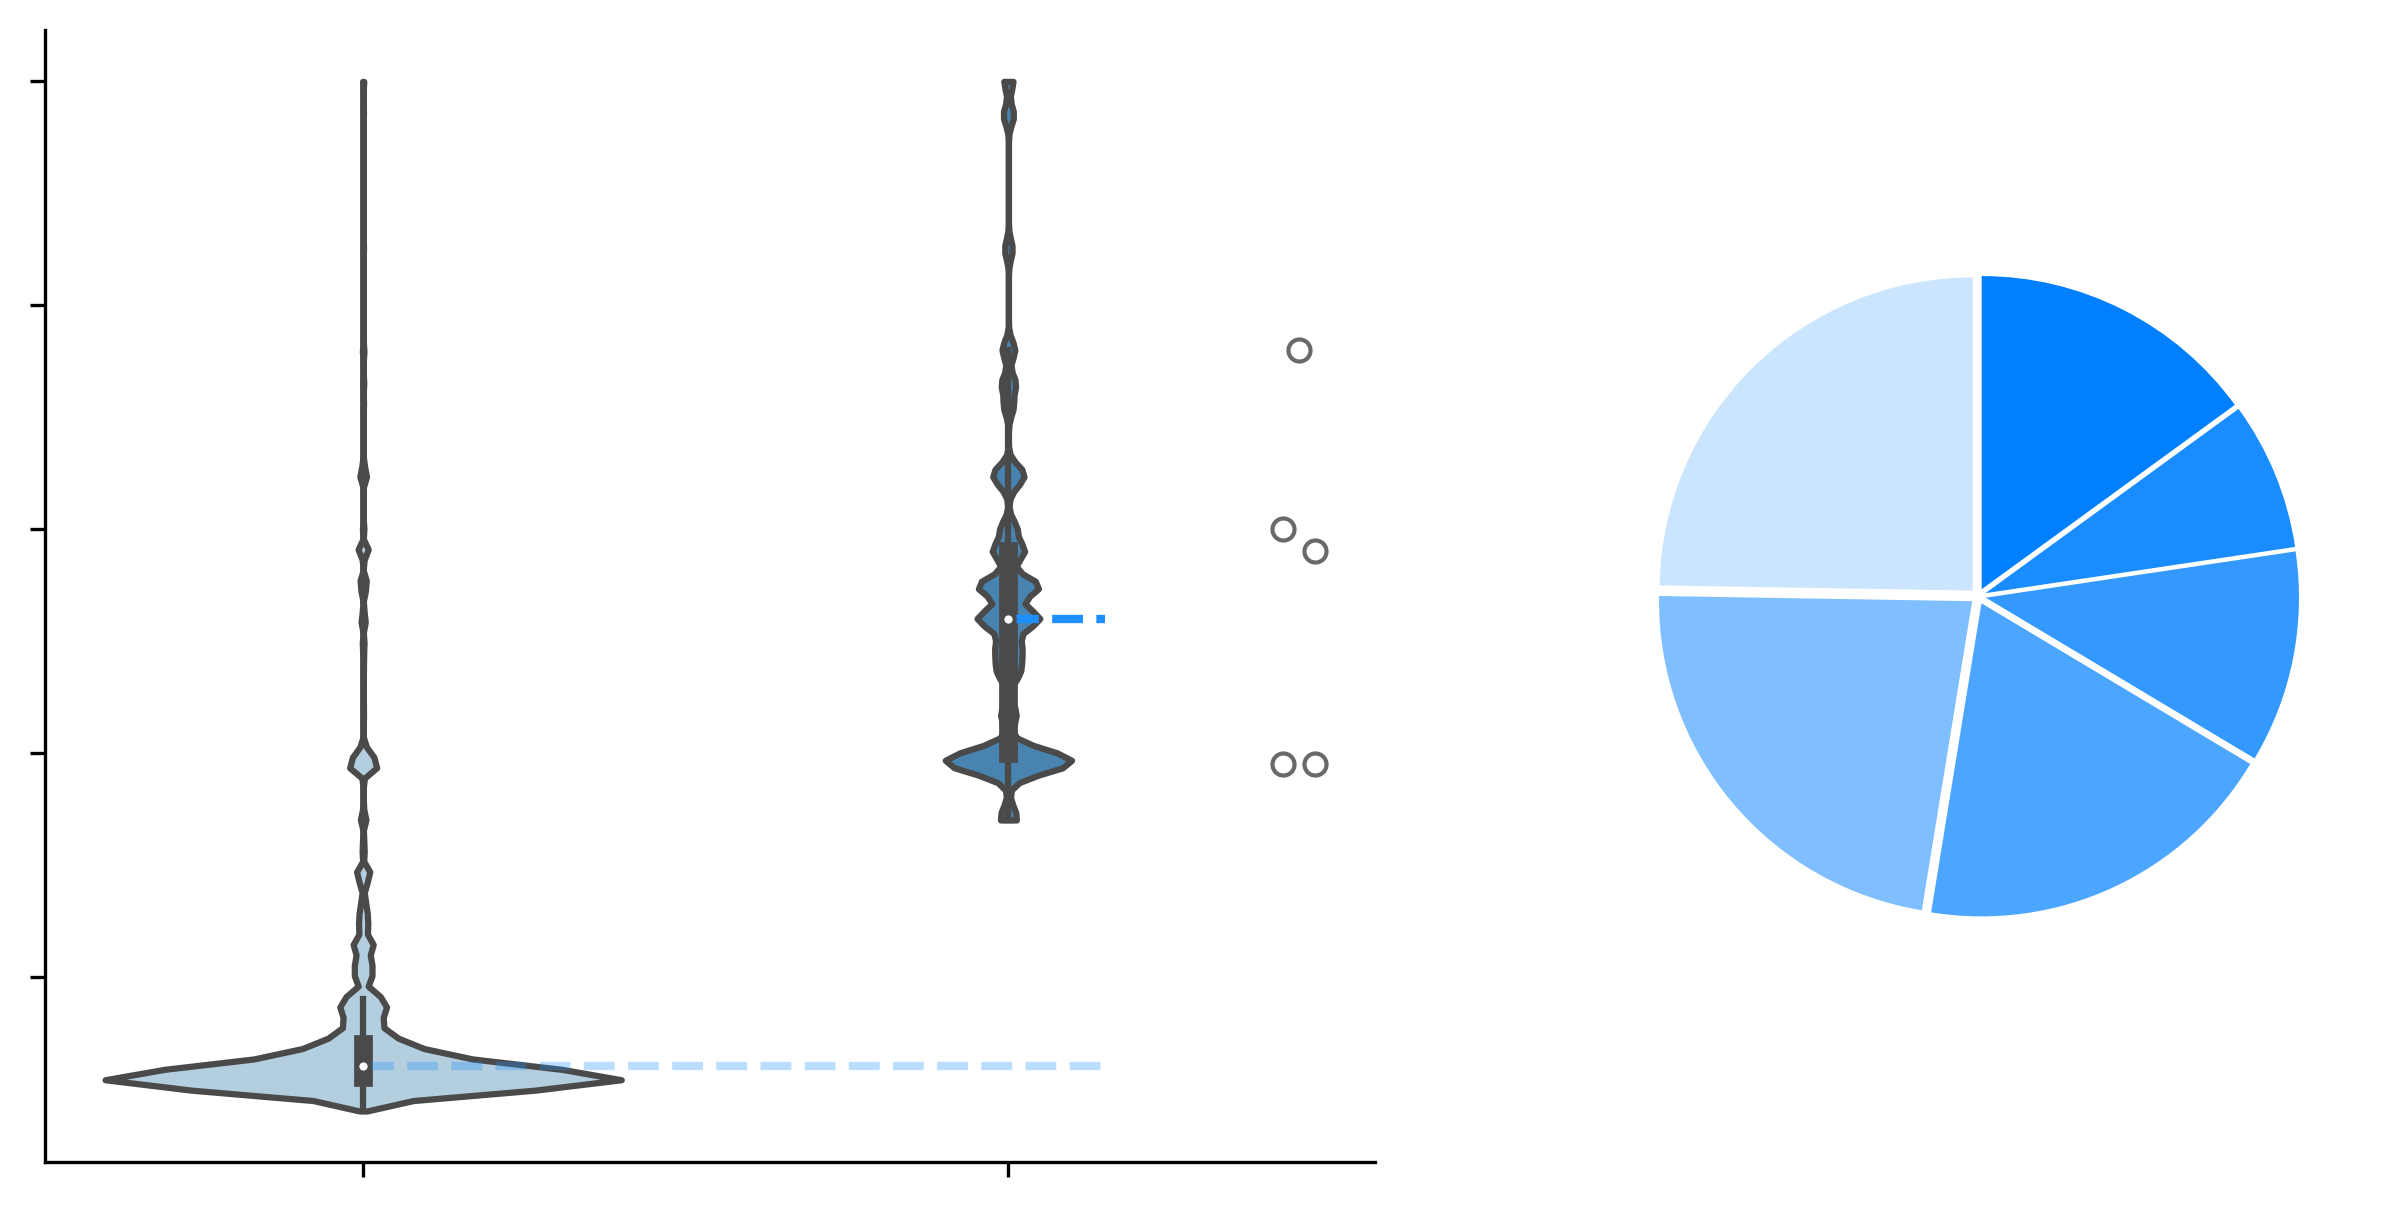

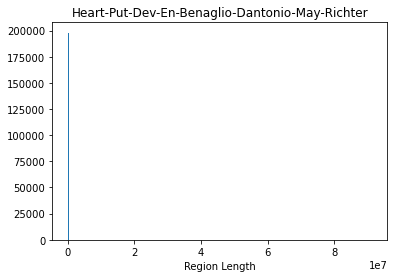

	 Heart-Put-Dev-En-Benaglio-Dantonio-May-Richter-associated-GWAS /home/solvason/projects/ets/heart/0-affinity-optimization-potential/human/8-heart-feta-enhancers-associated-gwas-dnv/putativeFetalEn-associated-gwas.bed
Heart-Put-Dev-En-Benaglio-Dantonio-May-Richter-associated-GWAS
	N Put Enhancers Total                             = 4,143
	N Put Enhancers With Dramatic Aff Increase        = 3,754 (90.6 %)

	N Ets in Put Enhancers Total                      = 2,808,424
	N Ets in Put Enhancers With Dramatic Aff Increase = 538,888 (19.2 %)

Average Putative Dev Enhancer ETS     = 0.12
Average Putative Dev Enhancer ETS-SNV = 0.52
(['GCTTCCGG', 'AAGGAAAT', 'TCTTCCGG', 'ACGGAAAC', 'CAGGAAGC'], [0, 1, -1, -1, 1])
[0.2, 0.5, 0.7, 0.8, 0.9, 1]


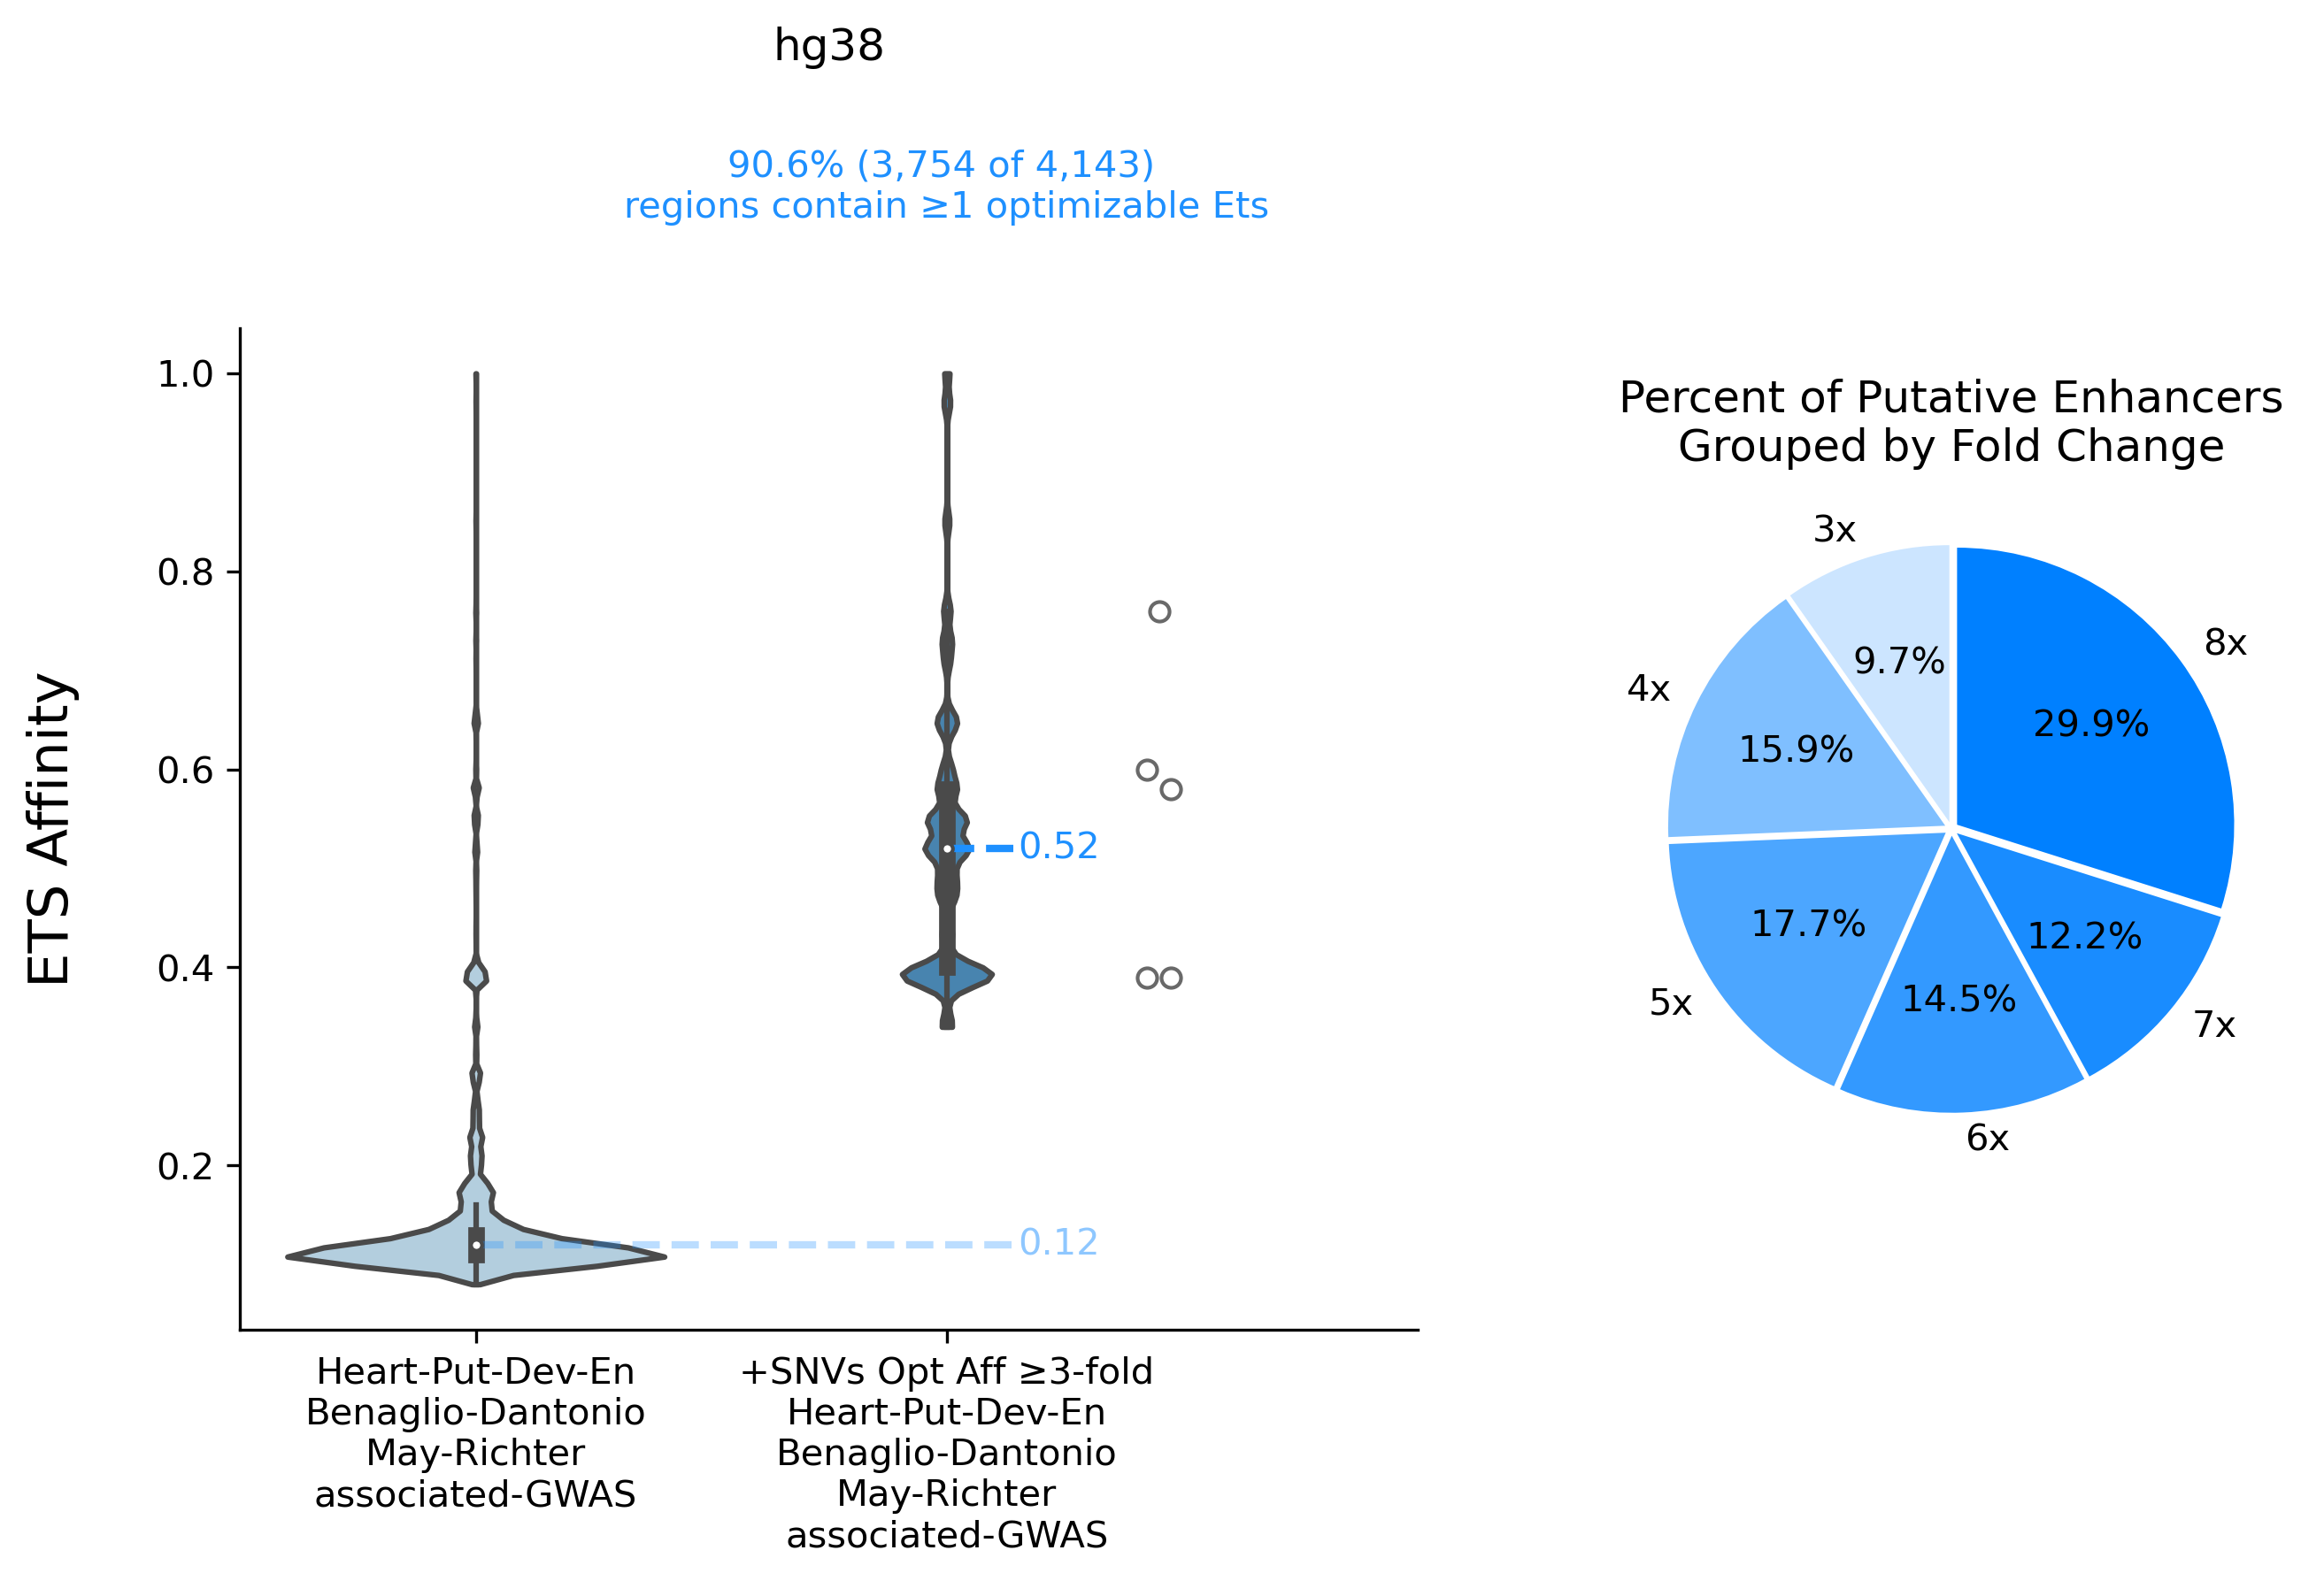

(['GCTTCCGG', 'AAGGAAAT', 'TCTTCCGG', 'ACGGAAAC', 'CAGGAAGC'], [0, 1, -1, -1, 1])
[0.2, 0.5, 0.7, 0.8, 0.9, 1]


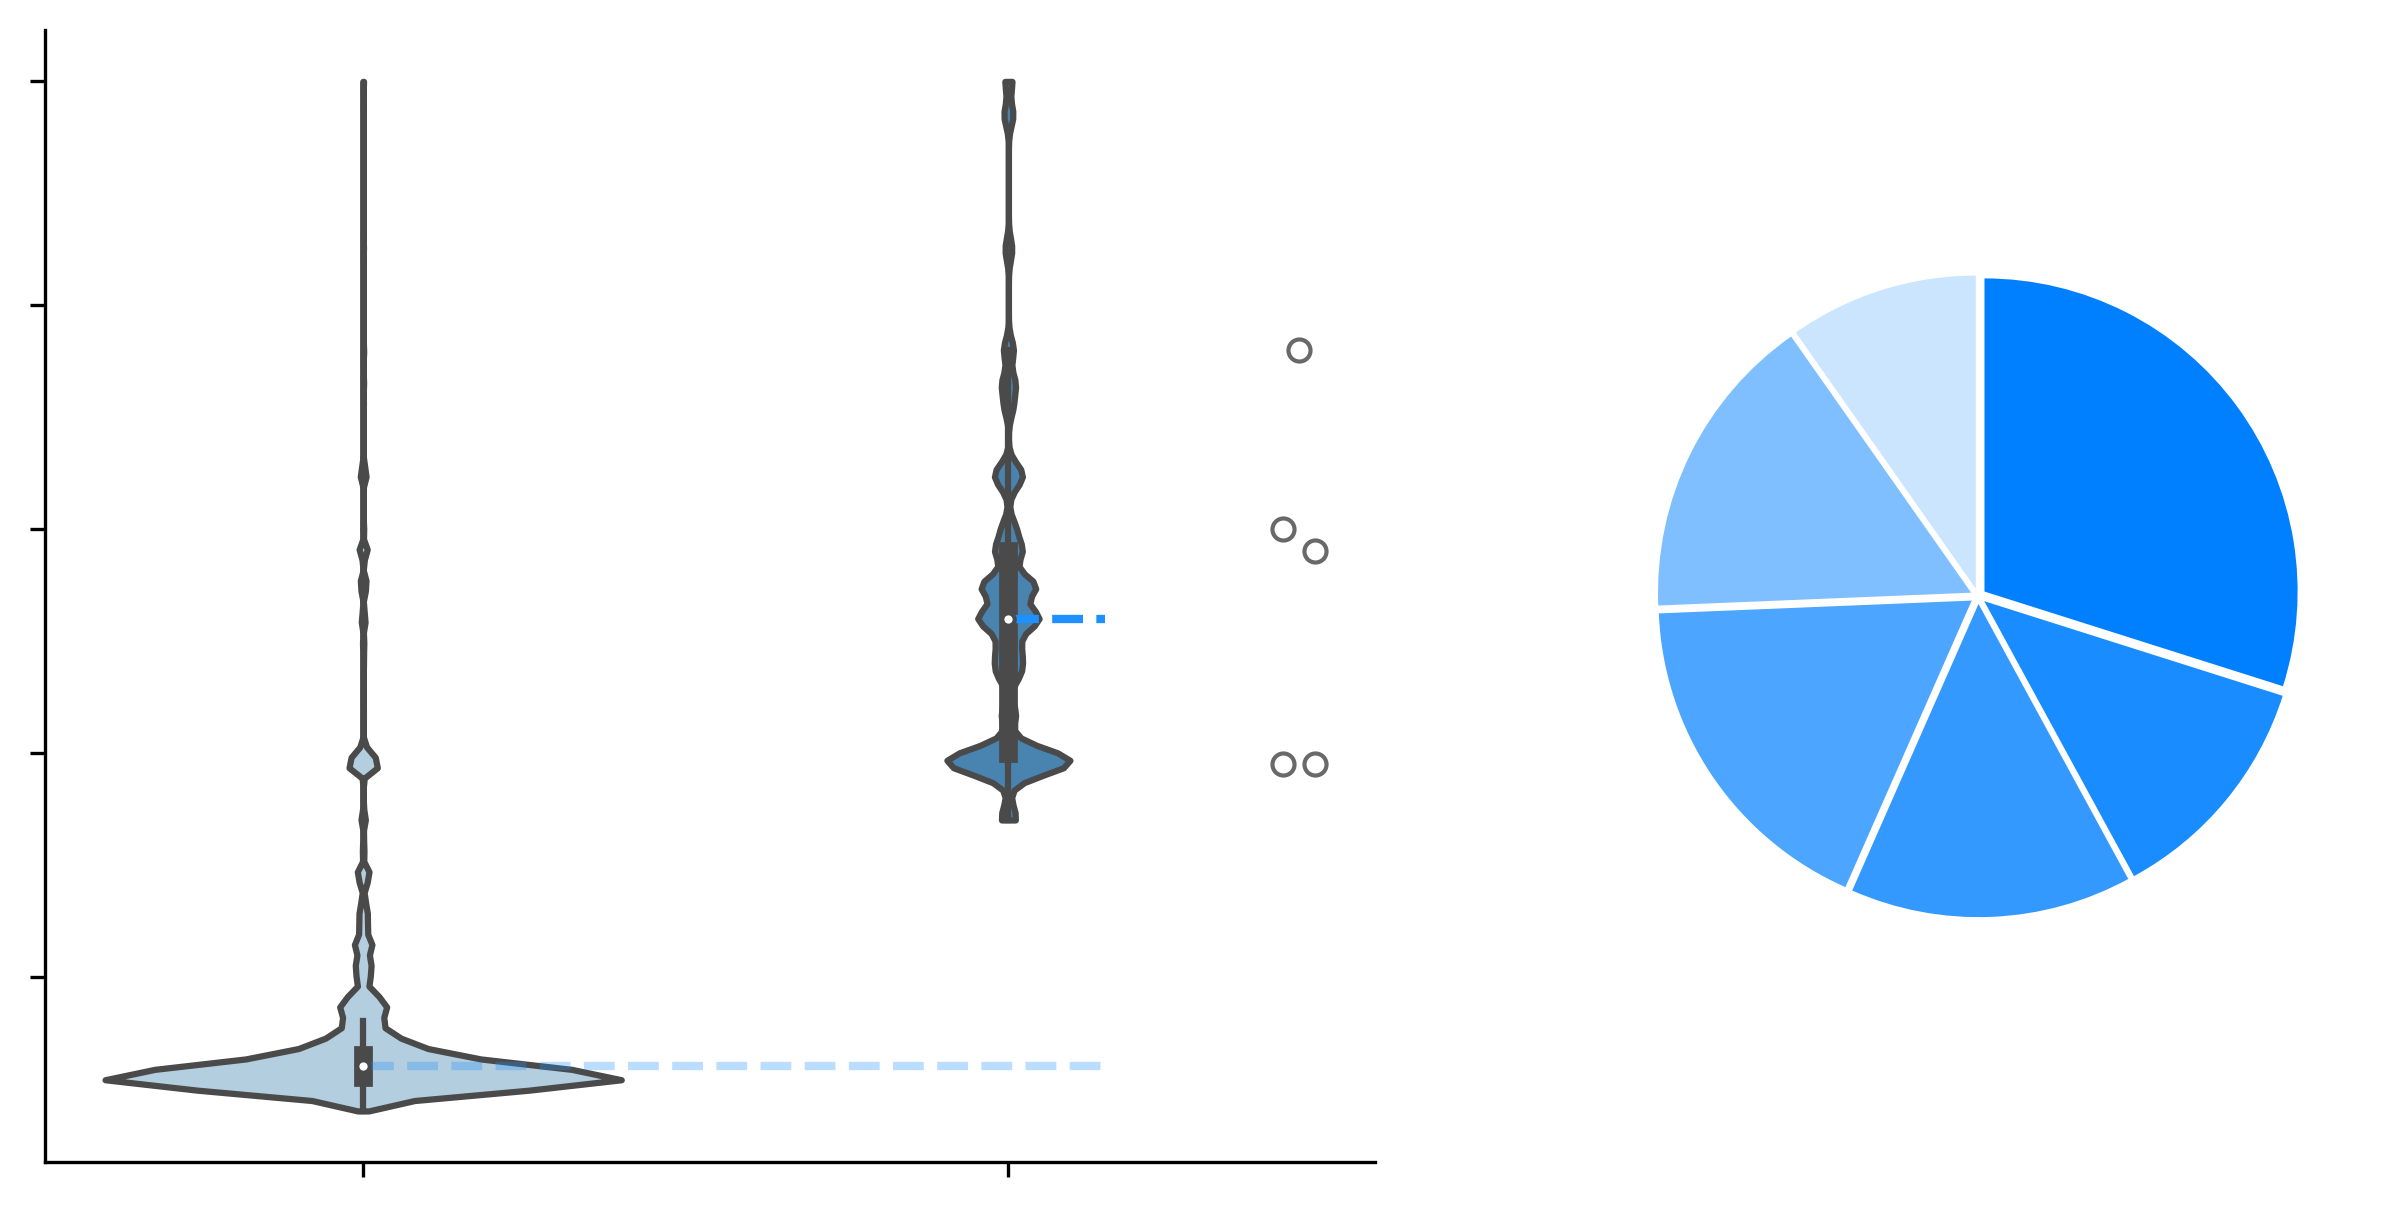

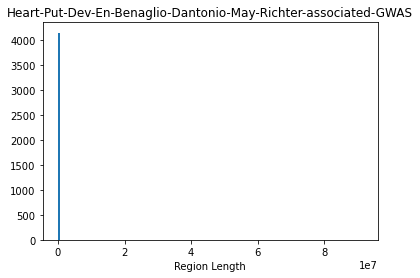

In [9]:
# Constants for barchart
FoldChangeBin2Name={
 '[0.0, 3.0)': 'Decrease Affinity\n or No Change',
 '[3.0, 4.0)': '3x Increase',
 '[4.0, 5.0)': '4x Increase',
 '[5.0, 6.0)': '5x Increase',
 '[6.0, 7.0)': '6x Increase',
 '[7.0, 8.0)': '7x Increase',
 '[8.0, inf)': '8x Increase',
}
Group2ColorAlpha={
'3x Increase'                     :('dodgerblue',.2),
'4x Increase'                     :('dodgerblue',.5),
'5x Increase'                     :('dodgerblue',.7),
'6x Increase'                     :('dodgerblue',.8),
'7x Increase'                     :('dodgerblue',.9),
'8x Increase'                     :('dodgerblue',1),
'Decrease Affinity\n or No Change':('grey',.7),
# 'Minor Increase (1-2x)'           :('grey',.9) 
}

groups=[
'3x Increase',                     
'4x Increase',                     
'5x Increase',                     
'6x Increase',                     
'7x Increase',                     
'8x Increase']
#         'Decrease Affinity\n or No Change',]

def my_autopct(pct):
    return (f'{int(pct)}%') if pct > 5 else ''

ets=set(['GGAA',jsd.revcomp('GGAA'),'GGAT',jsd.revcomp('GGAT')])
foldChangeCutoff=3

beta=False
maxBetaLines=1000

allData=[]
allDataLabels=[]
allAverageEtsAffs=[]

if beta==True: print('beta!!!   '*300,'\n\n\n')
for genome in ['Ci19','hg38']:

    print('---------------------------'*3)
    print(genome)
    print()
    
    # Set up datasets
    Name2KmerSeqAff2Count={}
    Name2FoldChanges     ={}
    
    Name2NPutEns={}
    Name2NEtsInPutEns={}
    
    Name2NPutEnsWithDramaticAffIncrease={}
    Name2NEsInPutEnsWithDramaticAffIncrease={}
    
    #####################################################################################
    # Analyze all datasets
    #####################################################################################
    
    Name2Bed=Genome2Name2Bed[genome]

    for name,bed in Name2Bed.items():
        print('\t',name,bed)
        
        # Set up this dataset
        Name2KmerSeqAff2Count[name]={}
        
        Name2NPutEns[name]=0
        Name2NEtsInPutEns[name]=0
        
        Name2NPutEnsWithDramaticAffIncrease[name]=0
        Name2NEsInPutEnsWithDramaticAffIncrease[name]=0
        
        # Read all lines
        MaxFoldChangeInPutEn=[]
        
        # Keep track of length distribution of regions
        regionLengthDist=[]
        
        # Begin reading file
        betaLineCount=0
        for row in js.read_tsv(bed,pc=False,header=False):
            betaLineCount+=1
            if betaLineCount>maxBetaLines and beta==True: break
                
            chrom,start,end=row[:3]
            start0=int(start)
            end0=int(end)

            regionLengthDist.append(end0-start0)
            
            Name2NPutEns[name]+=1
            thisPutEnHasDramaticAffIncrease=False
            maxEtsFoldChangedObserved=0
            
            
            for kmer8 in jsd.get_kmers(G2Chr2Seq[genome][chrom][start0:end0],8):
                
                thisEtsHasDramaticAffIncrease=False

                kmer8=kmer8.upper()
                if 'N' in kmer8: continue

                core=kmer8[2:6]

                if core in ets:
                    Name2NEtsInPutEns[name]+=1
                    
                    aff=Ets2RoundedAff[kmer8]

                    if (kmer8,aff) not in Name2KmerSeqAff2Count[name]:
                        Name2KmerSeqAff2Count[name][(kmer8,aff)]=0
                    Name2KmerSeqAff2Count[name][(kmer8,aff)]+=1
                    
                    SnvCausesDramaticIncrease,maxFoldChange=checkIfSnvCausesDramaticIncrease(kmer8,Ets2RoundedAff,foldChangeCutoff)
                    if SnvCausesDramaticIncrease:
                        if maxFoldChange>maxEtsFoldChangedObserved: maxEtsFoldChangedObserved=maxFoldChange
                        thisEtsHasDramaticAffIncrease  =True
                        thisPutEnHasDramaticAffIncrease=True
                        
                        
                if thisEtsHasDramaticAffIncrease:
                    Name2NEsInPutEnsWithDramaticAffIncrease[name]+=1
                    
            if thisPutEnHasDramaticAffIncrease:
                Name2NPutEnsWithDramaticAffIncrease[name]+=1
                MaxFoldChangeInPutEn.append(maxEtsFoldChangedObserved)
            else:
                MaxFoldChangeInPutEn.append(0)
            

        nPutTotal    = Name2NPutEns[name]
        nPutIncrease = Name2NPutEnsWithDramaticAffIncrease[name]
        
        print(name)
        print(f'\tN Put Enhancers Total                             = {nPutTotal:,}')
        print(f'\tN Put Enhancers With Dramatic Aff Increase        = {nPutIncrease:,} ({js.percent(nPutIncrease/nPutTotal)})')
        print()

        nEtsInPutTotal   =Name2NEtsInPutEns[name]
        nEtsInPutIncrease=Name2NEsInPutEnsWithDramaticAffIncrease[name]
        print(f'\tN Ets in Put Enhancers Total                      = {nEtsInPutTotal:,}')
        print(f'\tN Ets in Put Enhancers With Dramatic Aff Increase = {nEtsInPutIncrease:,} ({js.percent(nEtsInPutIncrease/nEtsInPutTotal)})')
        print()
        


        ################################################################
        # Determine all possible SNVs which create dramatic change
        ################################################################

        namePlusSnv='+SNV '+name
        Name2KmerSeqAff2Count[namePlusSnv]={}
        Name2FoldChanges[namePlusSnv]=[]

        for (kmer,aff),count in Name2KmerSeqAff2Count[name].items():

            # If low aff ets, see which snvs cause dramatic affinity increase
            for i in range(len(kmer)):

                # Create all possible snvs
                kmerDegenerate=kmer[:i]+'N'+kmer[i+1:]

                # Only keep snv if snv is in flank
                core=kmerDegenerate[2:6]
                if 'N' in core: continue

                allSnvs=jsd.GenerateAllPossibleSequences(kmerDegenerate)
                for snv in allSnvs:

                    snvAff=Ets2RoundedAff[snv]
                    foldChange=snvAff/aff
                    Name2FoldChanges[namePlusSnv].append(snvAff/aff)

                    # If affinity jump is sufficient, save 
                    if foldChange>=foldChangeCutoff:

                        if (snv,snvAff) not in Name2KmerSeqAff2Count[namePlusSnv]:
                            Name2KmerSeqAff2Count[namePlusSnv][(snv,snvAff)]=0
                        Name2KmerSeqAff2Count[namePlusSnv][(snv,snvAff)]+=count

        ################################################################
        # Violiin plot
        ################################################################

            
        # Data
        Name2AffArray={}
        for dname in Name2KmerSeqAff2Count:
            Name2AffArray[dname]=[]

            for (kmer,aff),count in Name2KmerSeqAff2Count[dname].items():
                Name2AffArray[dname]+=[aff]*count

        snvLabel='+SNVs Opt Aff ≥3-fold\n'
        data=[Name2AffArray[name],Name2AffArray[namePlusSnv]]
        allData+=data
        
        avgOpenAff = round(np.median(Name2AffArray[name]),2)
        avgSnvAff  = round(np.median(Name2AffArray[namePlusSnv]),2)

        print(f'Average Putative Dev Enhancer ETS     = {avgOpenAff}')
        print(f'Average Putative Dev Enhancer ETS-SNV = {avgSnvAff}')
        
        for text in [True,False]:

            # Figure
            fig,ax=plt.subplots(1,2,figsize=(10,5),dpi=300,facecolor='white',gridspec_kw={'width_ratios':[1.7,1], 'height_ratios':[1]})

            ############################################
            # Violin
            ############################################
            
            ax1=ax[0]
            x=sns.violinplot(data=data,ax=ax1,scale='count',palette='Blues',cut=0)
            
            ############################################
            # Plot dots of disease kmers
            ############################################
            print(Genome2Name2DiseaseKmers[genome][name])
            diseaseKmers,xAdjustCustom=Genome2Name2DiseaseKmers[genome][name]
            
            xAdjustScale=.025
            xcustom=[1.45+i*xAdjustScale for i in xAdjustCustom]
            
            diseaseKmerAffs=[Ets2RoundedAff[kmer] for kmer in diseaseKmers]
            x=ax1.scatter(x=xcustom,y=diseaseKmerAffs,color='white',marker='o',edgecolor='dimgrey',s=28)
            
            # AES
            if text:
                x=ax1.set_ylabel('ETS Affinity\n',size=15)
                x=ax1.set_title(genome+'\n\n\n\n\n')
                
            ax1.spines["right"].set_visible(False)
            ax1.spines["top"].set_visible(False)

            # dashed line at average affinity
            ax1.hlines(y=avgOpenAff, xmin=0, xmax=1.15, linewidth=2, color='dodgerblue',alpha=.3,ls='--')
            ax1.hlines(y=avgSnvAff, xmin=1, xmax=1.15, linewidth=2,  color='dodgerblue',alpha=1,ls='--')
            
            allAverageEtsAffs+=[avgOpenAff,avgSnvAff]
            
            if text:
                ax1.text(1.15,avgOpenAff,avgOpenAff,va='center',color='dodgerblue',alpha=.5)
                ax1.text(1.15,avgSnvAff,avgSnvAff,va='center',color='dodgerblue',alpha=1)

            # xticklabels
            if text:
                xlabels=[Name2Xlabel[name],snvLabel+Name2Xlabel[name]]
                allDataLabels+=xlabels
                x=ax1.set_xticklabels(xlabels)

            # Plot how many regions were able to be optimized
            percentRegionsOptimized=f'{round(100*nPutIncrease/nPutTotal,1)}%'
            if text:
                ax1.text(1,1.15,f'\n{percentRegionsOptimized} ({nPutIncrease:,} of {nPutTotal:,}) \nregions contain ≥1 optimizable Ets',ha='center',color='dodgerblue',va='bottom')

            #################################################################
            # Pie Chart
            #################################################################

            # Set xlim to allow barplot to be included
            if text: ax1.set_xlim(-.5,2)

            data_pie=pd.Series(MaxFoldChangeInPutEn)
            data_pie=pd.cut(data_pie,bins=[0,3,4,5,6,7,8,np.inf],right=False).value_counts()
            FoldChangeGroup2Count={str(b):c for b,c in zip(data_pie.index,data_pie.tolist())}

            FoldChangeGroup2Count={FoldChangeBin2Name[b]:c for b,c in FoldChangeGroup2Count.items()}

            labels=[g for g in groups]
            counts=[FoldChangeGroup2Count[g] for g in groups]
            alphas=[Group2ColorAlpha[g][1] for g in groups]
            colors=[(72/255, 195/255, 68/255, a) for a in alphas]
            colors=[(0/255, 128/255, 255/255, a) for a in alphas]
            print(alphas)

            if pop: explode = [.025 for g in groups]
            else:   explode = [0 for g in groups]

            # pie            
            ax2=ax[1]
            if text: ax2.pie(counts, explode=explode, labels=[l[:2] for l in labels],shadow=False, startangle=90,colors=colors, autopct=lambda pct: f"{pct:.1f}%" if pct>7 else '' )
            else:    ax2.pie(counts, explode=explode, labels=['' for l in labels],shadow=False, startangle=90,colors=colors)
            if text:
                ax2.set_title('Percent of Putative Enhancers\nGrouped by Fold Change')

            # remove all text
            if not text:
                for a in [ax1,ax2]:
                    a.set_yticklabels([])
                    a.set_xticklabels([])



            plt.show()

            figname=name.replace('\n',' ').replace('(','').replace(')','').replace('.','')
            fig.savefig(f"{figname}.text={text}.violin.svg", format="svg",dpi=300,bbox_inches='tight')
            fig.savefig(f"{figname}.text={text}.violin.png", format="png",dpi=300,bbox_inches='tight')


        # hist of region lengths
        plt.hist(regionLengthDist,bins=200)
        plt.title(name)
        plt.xlabel('Region Length')
        plt.show()


# Plot on same x axis

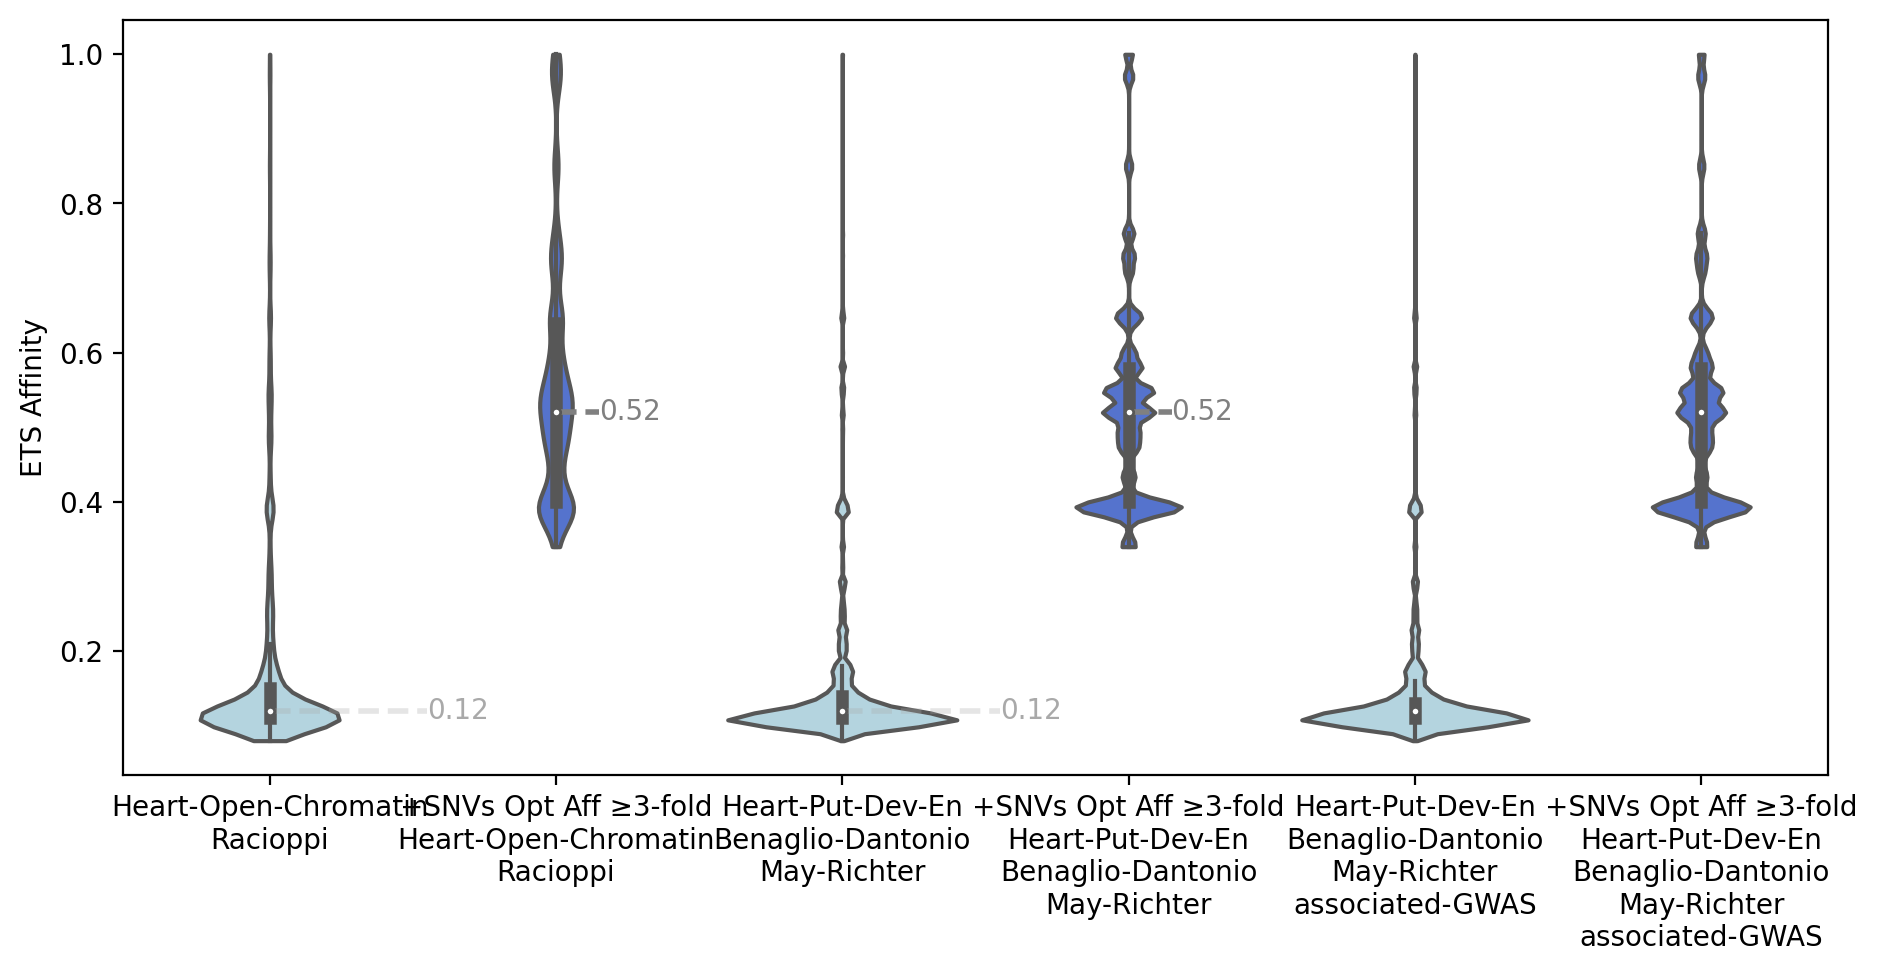

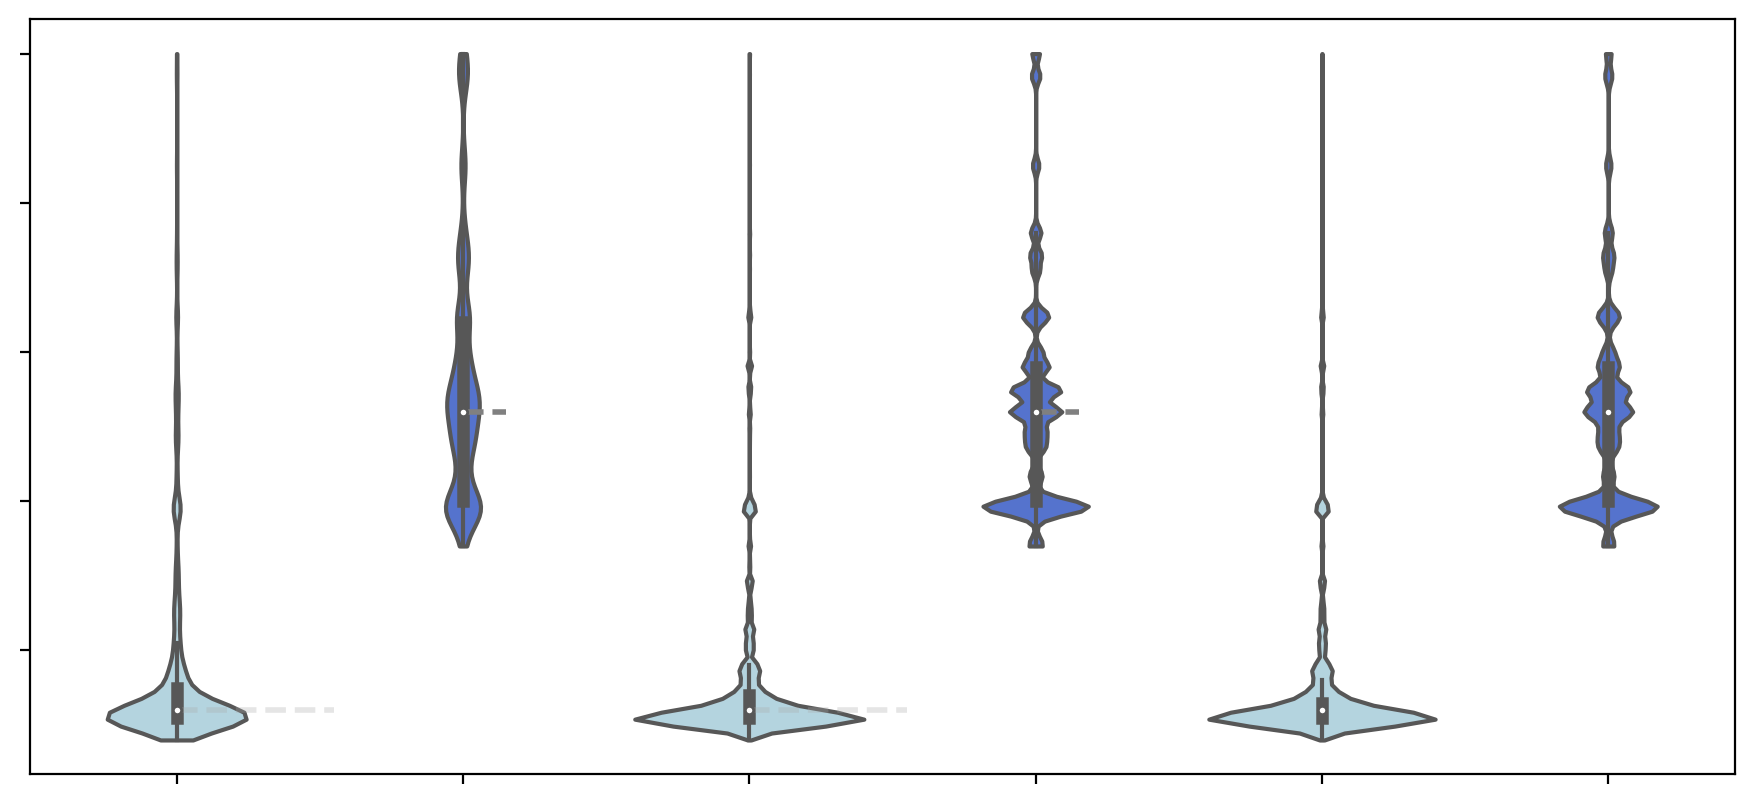

In [10]:
# Recall you have the following data
# allData=[]
# allDataLabels=[]
# allAverageEtsAffs=[]

for text in [True,False]:

    fig,ax=plt.subplots(1,figsize=(11,5),dpi=200)

    sns.violinplot(data=allData,ax=ax,scale='area',palette=['lightblue','royalblue']*2,cut=0)

    for i,avgOpenAff in enumerate([allAverageEtsAffs[0],'NA',allAverageEtsAffs[2],'NA']):
        if avgOpenAff=='NA': continue
        ax.hlines(y=avgOpenAff, xmin=i+0, xmax=i+.55, linewidth=2, color='darkgrey',alpha=.3,ls='--')
        if text: ax.text(y=avgOpenAff,x=i+.55,s=avgOpenAff,va='center',color='darkgrey')

    for i,avgSnvAff in enumerate([allAverageEtsAffs[1],'NA',allAverageEtsAffs[3]]):
        if avgSnvAff=='NA': continue
        ax.hlines(y=avgSnvAff, xmin=i+1, xmax=i+1.15, linewidth=2,  color='grey',alpha=1,ls='--')
        if text: ax.text(y=avgSnvAff,x=i+1.15,s=avgSnvAff,va='center',color='grey')

    if text: ax.set_xticklabels(allDataLabels)
    if text: ax.set_ylabel('ETS Affinity')
    
    else:    ax.set_xticklabels([])
    if not text: ax.set_yticklabels([])
    
    plt.show()
    
    fig.savefig(f"merged-xaxis.text={text}.violin.png", format="png",dpi=300)